In [219]:
%matplotlib widget
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

In [11]:
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
first_day = dt.date(2017,8,23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= first_day).\
    order_by(Measurement.date).all()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

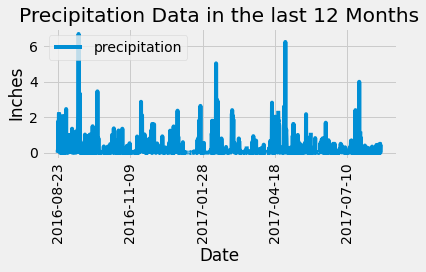

In [221]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp,columns=['date','precipitation'])
prcp_df.set_index('date',inplace=True)
# Sort the dataframe by date
prcp_df = prcp_df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind='line',title='Precipitation Data in the last 12 Months')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("images/precipitation.png")

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
inspector.get_columns('station')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [16]:
# Design a query to show how many stations are available in this dataset?
how_many_station = session.query(Measurement.station).group_by(Measurement.station).count()
how_many_station

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel_2 = [Station.station,
    Station.name,
    func.count(Measurement.station)]
stations_ranking = session.query(*sel_2).filter(Station.station == Measurement.station).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()
stations_ranking

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
the_most_active_station_id = stations_ranking[0][0]
the_most_active_station_id

sel_3 = [func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)]

query_3 = session.query(*sel_3).group_by(Measurement.station).\
        filter(Measurement.station == the_most_active_station_id).all()


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel_4 = [Station.station,
         Station.name,
         func.count(Measurement.tobs)]

station_highest_obs = session.query(*sel_4).filter(Station.station == Measurement.station).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.tobs).desc()).first()
# station_highest_obs
station_highest_obs_id = station_highest_obs[0]
station_highest_obs_id

'USC00519281'

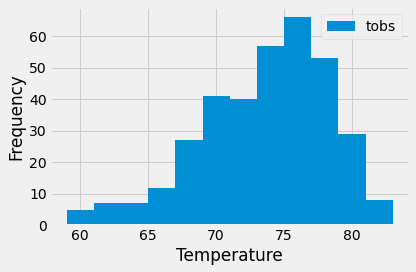

In [216]:
temp = session.query(Measurement.date,Measurement.tobs).\
       filter(Measurement.station == station_highest_obs_id).\
       filter(Measurement.date >= first_day).all()
       

temp_df = pd.DataFrame(temp,columns=['date','tobs'])
temp_df = temp_df.sort_values(by='date')

x = temp_df['tobs'].to_list()
plt.hist(x,bins=12,label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig("images/station-histogram.png")

## Bonus Challenge Assignment

### t-test

In [140]:
from scipy.stats import ttest_ind

In [157]:
june = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "06").all()
dec = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "12").all()

In [158]:
june_list = list(np.ravel(june))
dec_list = list(np.ravel(dec))

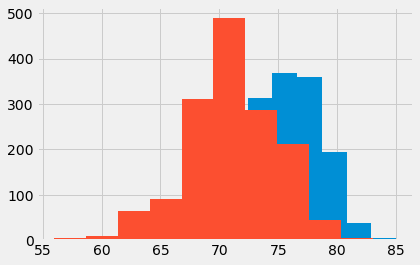

In [173]:
fig, ax = plt.subplots(1)
ax1 = plt.hist(june_list)
ax2 = plt.hist(dec_list)

As we extract data from two months, they are not related. Therefore, I would use independent t-test.

In [164]:
ttest_ind(june_list, dec_list,equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

There is a statistically significant difference between these two samples.

In [183]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [185]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-01-01','2017-01-07'))

[(62.0, 68.36585365853658, 74.0)]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/Sean/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


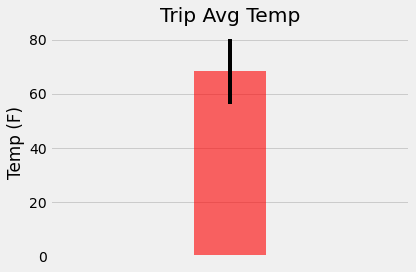

In [223]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
result_bonus = calc_temps('2017-01-01','2017-01-07')

height = result_bonus[0][1]
yerr = result_bonus[0][2] - result_bonus[0][0]


plt.bar(x = 'chosen period', height = height, yerr = yerr,color='red',alpha = 0.6)

ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

plt.xlim(-2,2)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.tight_layout()
plt.savefig("images/temperature.png")


In [62]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station,
      Station.name,
      Station.latitude,
      Station.longitude,
      Station.elevation,]

session.query(*sel).filter(Measurement.station == Station.station).\
                    group_by(Station.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [97]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [111]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2018-01-01'
end_date = '2018-01-07'
# Use the start and end date to create a range of dates
dates = [dt.date(2018,1,7)-dt.timedelta(days=x) for x in range(7)]
# Stip off the year and save a list of %m-%d strings
month_list=[]
day_list=[]
for date in dates:
    month_list.append(date.strftime("%m"))
    day_list.append(date.strftime("%d"))
dates_list=[]
for i in range(0,len(month_list)):
    dates_list.append(f'{month_list[i]}-{day_list[i]}')
# Loop through the list of %m-%d strings and calculate the normals for each date
norms=[]
for date in dates_list:
    norms += daily_normals(date)
    
norms

[(57.0, 68.54385964912281, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (58.0, 70.0, 76.0),
 (62.0, 68.9090909090909, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 69.15384615384616, 77.0)]

In [130]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
norm_df = pd.DataFrame(norms,columns=['tmin','tavg','tmax'])
norm_df['date'] = dates
norm_df.set_index('date',inplace=True)
norm_df.sort_index(inplace=True)
norm_df

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

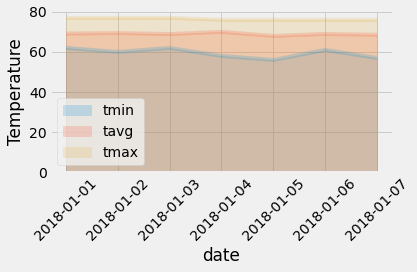

In [224]:
# Plot the daily normals as an area plot with `stacked=False`
norm_df.plot(kind='area',stacked=False,alpha=0.2)
plt.xticks(rotation=45)
plt.ylabel('Temperature')
plt.tight_layout()
plt.savefig('images/daily-normals.png')

In [29]:
dt.date(2017,8,23) - dt.date(2010,1,1)

datetime.timedelta(2791)